In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math

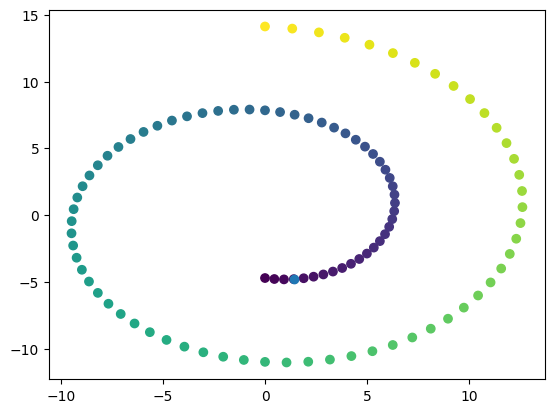

In [61]:
N = 100

phi = np.linspace(1.5*math.pi, 4.5*math.pi, N)

x = phi*np.cos(phi)
y = phi*np.sin(phi)

X = np.array([x,y]).reshape(2,N).T

plt.scatter(x,y, c = phi)

plt.scatter(X[3,0], X[3,1])


### PCA $\sim$ CLASSICAL MDS

In [4]:
def my_PCA(X, k):
    """
    X: dataframe
        dataframe with n observation and p features (nxp)
    k: int
        number of principal components we want to project on
    output: array-shape
        return the projected data (nxk), where k is the number of principal components we have projected on
    """

    # center the data
    X_std = X - X.mean(axis=0)

    # compute the covariance matrix
    cov_mat = np.dot(X_std.T, X_std)

    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    
    sorted_indices = np.argsort(eig_vals)[::-1]
    sorted_eigvecs = eig_vecs[:,sorted_indices]
    
    top_k_eigvecs = sorted_eigvecs[:k]

    projection_matrix = top_k_eigvecs.T

    return np.dot(X, projection_matrix)

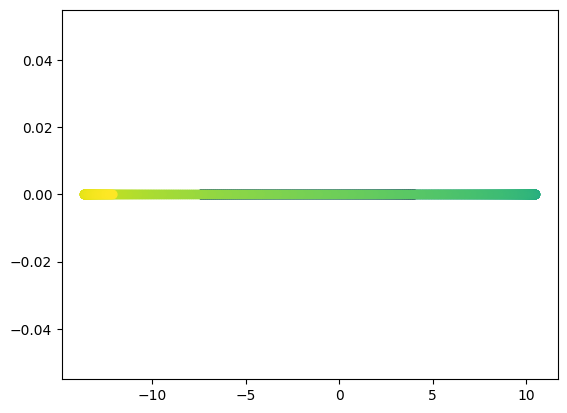

In [12]:
Y = (my_PCA(X,1))

first_comp = [Y[i][0] for i in range(X.shape[0])]
#second_comp = [Y[i][1] for i in range(X.shape[0])]
second_comp = [0 for i in range(X.shape[0])]


plt.scatter(first_comp, second_comp, c = phi)


### ISOMAP

In [23]:
from sklearn.neighbors import NearestNeighbors

# K nearest neighbors
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

# Construct neighborhood graph
graph = nbrs.kneighbors_graph(X).toarray()


In [24]:
from math import inf

n_nodes = graph.shape[0]

for i in range(n_nodes):
    for j in range(n_nodes):
        if i != j and graph[i][j]== 0:
            graph[i][j] = inf


for k in range(n_nodes):
    for i in range(n_nodes):
        for j in range(n_nodes):
            if graph[i][j] > graph[i][k] + graph[k][j]:
                graph[i][j] = graph[i][k] + graph[k][j]

In [25]:
J = np.eye(n_nodes) - 1/n_nodes * np.dot(np.ones(n_nodes), np.ones(n_nodes).T)

B = -1/2 * np.dot(J, np.dot(graph, J))

In [26]:
eig_vals, eig_vecs = np.linalg.eig(B)

sorted_indices = np.argsort(eig_vals)[::-1]
sorted_eigvecs = eig_vecs[:,sorted_indices]

top_k_eigvecs = sorted_eigvecs[:1]

projection_matrix = top_k_eigvecs.T

Y = np.dot(B, projection_matrix)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


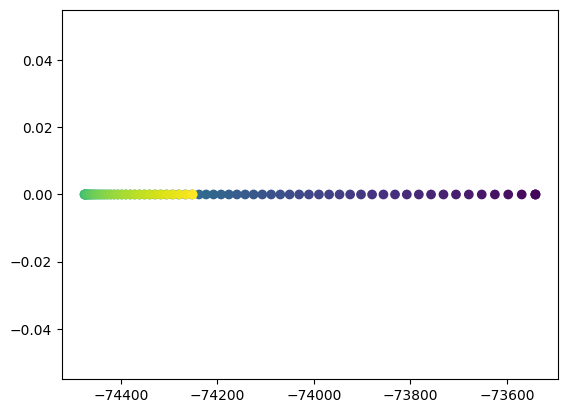

In [27]:
first_comp = [Y[i][0] for i in range(X.shape[0])]
#second_comp = [Y[i][1] for i in range(X.shape[0])]
second_comp = [0 for i in range(X.shape[0])]


plt.scatter(first_comp, second_comp, c = phi)

Design my algorithm fo isomap

In [64]:
from sklearn.neighbors import NearestNeighbors
from math import inf

def my_ISOMAP(X, k, n_neighbors=5, radius = 1.0):
    """
    X: dataframe
        dataframe with n observation and p features (nxp)
    k: int
        number of principal components we want to project on
    n_neighbors: int
        number of neighbors to take into account to build the graph of geodesic distance
    radius: float
        radius to use inside sklearn.neighbors.NearestNeighbors algorithm
    output: array-shape
        return the projected data (nxk), where k is the number of principal components we have projected on

    The algorithm procedes as follows:
        - for each point, select the n_neighbors nearest neighbor(s)
        - compute the graph (geodesic) distance using: graph[i,j] == 1 iff point i is one of the n_neighbors nearest neighbor(s) of point j
        - apply floyd-warshall algorithm to the previous graph
        - apply double centering on the adiaceny matrix of the graph obtained before
        - compute the eigenvalues/eigenvectors decomposition
        - choose the first k eigenvector(s)
    """
    
    # K nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree', radius = radius).fit(X)
    #distances, indices = nbrs.kneighbors(X)

    # Construct neighborhood graph
    graph = nbrs.kneighbors_graph(X).toarray()

    # apply floyd-warshall
    n_nodes = graph.shape[0]

    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j and graph[i][j]== 0:
                graph[i][j] = inf


    for k in range(n_nodes):
        for i in range(n_nodes):
            for j in range(n_nodes):
                if graph[i][j] > graph[i][k] + graph[k][j]:
                    graph[i][j] = graph[i][k] + graph[k][j]

    
    # apply double centering on graph adiacency matrix
    J = np.eye(n_nodes) - 1/n_nodes * np.dot(np.ones(n_nodes), np.ones(n_nodes).T)

    B = -1/2 * np.dot(J, np.dot(graph, J))

    # eigenvector decomposition
    eig_vals, eig_vecs = np.linalg.eig(B)

    sorted_indices = np.argsort(eig_vals)[::-1]
    sorted_eigvecs = eig_vecs[:,sorted_indices]

    # select the first k eigenvector(s) and project
    top_k_eigvecs = sorted_eigvecs[:k]

    projection_matrix = top_k_eigvecs.T

    return np.dot(B, projection_matrix)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


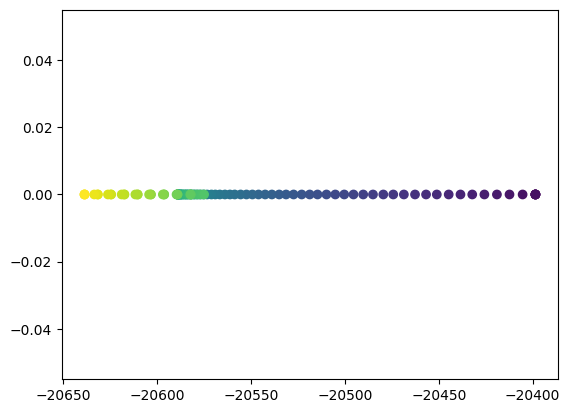

In [65]:
Y = my_ISOMAP(X, k=1, radius= 1.0, n_neighbors=8)

first_comp = [Y[i][0] for i in range(X.shape[0])]
#second_comp = [Y[i][1] for i in range(X.shape[0])]
second_comp = [0 for i in range(X.shape[0])]


plt.scatter(first_comp, second_comp, c = phi)

Apply on swiss roll

In [47]:
def swiss_roll(n): #from lab 1
    """
    Parameters:
    n: int
        Number of points to generate"""
    
    data = np.zeros((n,3))
    phi = np.random.uniform(low=1.5*np.pi, high=4.5*np.pi, size=n)
    psi = np.random.uniform(0,10,n)
            
    data[:,0]=phi*np.cos(phi) #x coordinte
    data[:,1]=phi*np.sin(phi) #y coordinate
    data[:,2]=psi #z coordinate
    return data

In [48]:
X = swiss_roll(200)

<class 'matplotlib.axes._subplots.Axes3DSubplot'>


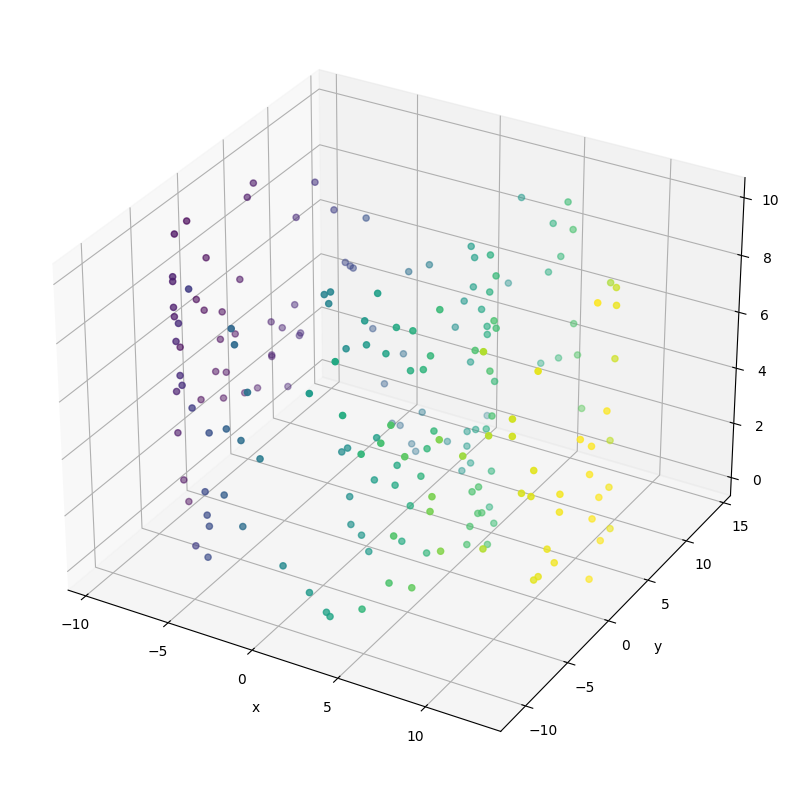

In [49]:
plt.figure(figsize=(12,10))
axes = plt.axes(projection='3d')
print(type(axes))
axes.scatter3D(X[:,0], X[:,1], X[:,2],c=X[:,0])

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_zlabel('z')

#axes.view_init(45, 45) #(elevation, azimuth angle)

plt.show()

In [57]:
Y = my_ISOMAP(X, k=2, n_neighbors=10, radius=10.0)

In [59]:
Y

array([[ -9797.1746792 +27.93423295j, -46587.39298964-63.37794908j,
        -24196.71082535 +8.16089864j, ...,  64123.47143409+45.15522705j,
         26211.44752481-25.79032698j,  40647.71522441+19.75257371j],
       [ -9809.83263987+28.07758978j, -46649.74845156-65.80134592j,
        -24227.93941599 +8.47088197j, ...,  64206.59146197+45.63413095j,
         26248.46990646-26.73492827j,  40700.15184659+20.15656871j],
       [ -9775.39670837+28.74369943j, -46485.56630672-62.31578474j,
        -24142.85934625 +8.63239989j, ...,  63979.06213879+45.65733735j,
         26152.77897806-24.73542909j,  40556.51555283+19.58150382j],
       ...,
       [ -9784.61142968+28.50630672j, -46528.47113292-62.8014718j ,
        -24165.5712294  +8.53987195j, ...,  64039.62046548+45.56199296j,
         26177.33690636-24.9934051j ,  40594.89780489+19.61162331j],
       [ -9773.39335114+28.78521786j, -46478.01899646-63.19256734j,
        -24137.97703039 +8.68744707j, ...,  63966.02684939+45.75492072j,
       

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


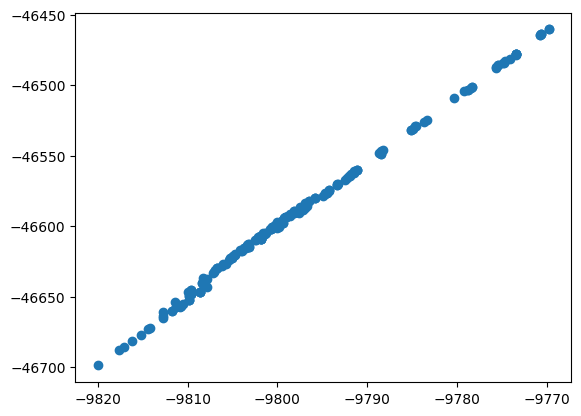

In [58]:
plt.plot(Y[:,0], Y[:,1], 'o')